# Time Series Analysis - Stock Price Prediction

## Project Overview
This project demonstrates advanced time series analysis techniques for stock price prediction. The analysis covers data preprocessing, trend analysis, seasonality detection, technical indicators, forecasting models, and investment insights.

## Learning Objectives
- Master time series analysis techniques
- Understand trend and seasonality components
- Implement forecasting models (ARIMA, Moving Average)
- Calculate technical indicators
- Generate investment insights and strategies

## Dataset Information
- **Source**: Stock price data (sample/dummy data)
- **Records**: 50 days of daily stock data
- **Time Period**: January 2023 - February 2023
- **Variables**: Date, Open, High, Low, Close, Volume


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Time series specific libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")
print("Time series analysis tools ready for stock price prediction")


Libraries imported successfully!
Time series analysis tools ready for stock price prediction


## 1. Data Loading and Initial Exploration


In [2]:
# Load the dataset
df = pd.read_csv('stock_price_data.csv')

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumn Information:")
print(df.dtypes)
print("\nFirst 5 rows:")
print(df.head())
print("\nLast 5 rows:")
print(df.tail())
print("\nBasic Statistics:")
print(df.describe())


Dataset Shape: (51, 5)

Column Information:
open      float64
high      float64
low       float64
close     float64
volume      int64
dtype: object

First 5 rows:
              open    high    low   close   volume
date                                              
2023-01-01  100.50  105.20   99.8  103.45  1500000
2023-01-02  103.45  106.75  102.3  105.20  1800000
2023-01-03  105.20  108.90  104.6  107.85  2100000
2023-01-04  107.85  110.30  106.5  109.45  1900000
2023-01-05  109.45  112.80  108.2  111.25  2200000

Last 5 rows:
              open   high    low   close   volume
date                                             
2023-02-16  192.90  195.4  192.0  194.45  6100000
2023-02-17  194.45  197.8  193.6  196.90  6200000
2023-02-18  196.90  199.3  195.8  198.25  6300000
2023-02-19  198.25  201.6  197.4  200.80  6400000
2023-02-20  200.80  203.2  199.9  202.35  6500000

Basic Statistics:
             open        high         low       close        volume
count   51.000000   51.000000

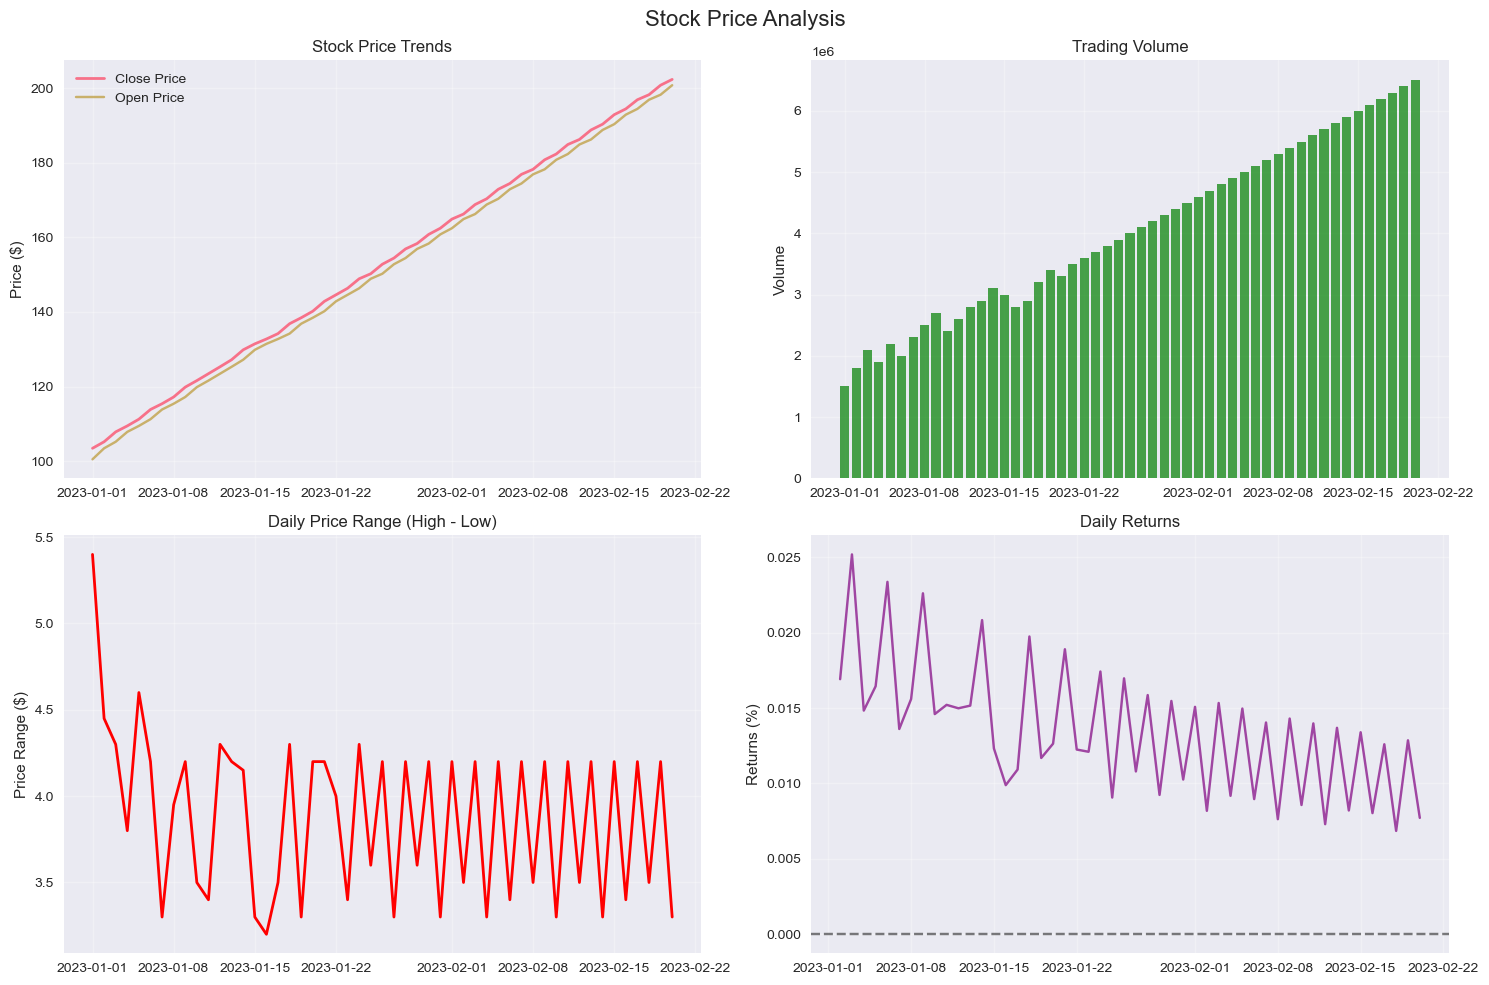

Key Statistics:
Average closing price: $152.85
Price volatility (std): $29.41
Maximum price: $203.20
Minimum price: $99.80
Average daily return: 0.0135 (1.35%)
Return volatility: 0.0043 (0.43%)


In [3]:
# Time series visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Stock Price Analysis', fontsize=16)

# Price trends
ax1 = axes[0, 0]
ax1.plot(df.index, df['close'], label='Close Price', linewidth=2)
ax1.plot(df.index, df['open'], label='Open Price', alpha=0.7)
ax1.set_title('Stock Price Trends')
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Volume analysis
ax2 = axes[0, 1]
ax2.bar(df.index, df['volume'], alpha=0.7, color='green')
ax2.set_title('Trading Volume')
ax2.set_ylabel('Volume')
ax2.grid(True, alpha=0.3)

# Price range (High-Low)
ax3 = axes[1, 0]
price_range = df['high'] - df['low']
ax3.plot(df.index, price_range, color='red', linewidth=2)
ax3.set_title('Daily Price Range (High - Low)')
ax3.set_ylabel('Price Range ($)')
ax3.grid(True, alpha=0.3)

# Returns analysis
ax4 = axes[1, 1]
returns = df['close'].pct_change().dropna()
ax4.plot(df.index[1:], returns, color='purple', alpha=0.7)
ax4.set_title('Daily Returns')
ax4.set_ylabel('Returns (%)')
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("001.png")
plt.show()

# Calculate and display key statistics
print("Key Statistics:")
print(f"Average closing price: ${df['close'].mean():.2f}")
print(f"Price volatility (std): ${df['close'].std():.2f}")
print(f"Maximum price: ${df['high'].max():.2f}")
print(f"Minimum price: ${df['low'].min():.2f}")
print(f"Average daily return: {returns.mean():.4f} ({returns.mean()*100:.2f}%)")
print(f"Return volatility: {returns.std():.4f} ({returns.std()*100:.2f}%)")


## 2. Technical Indicators


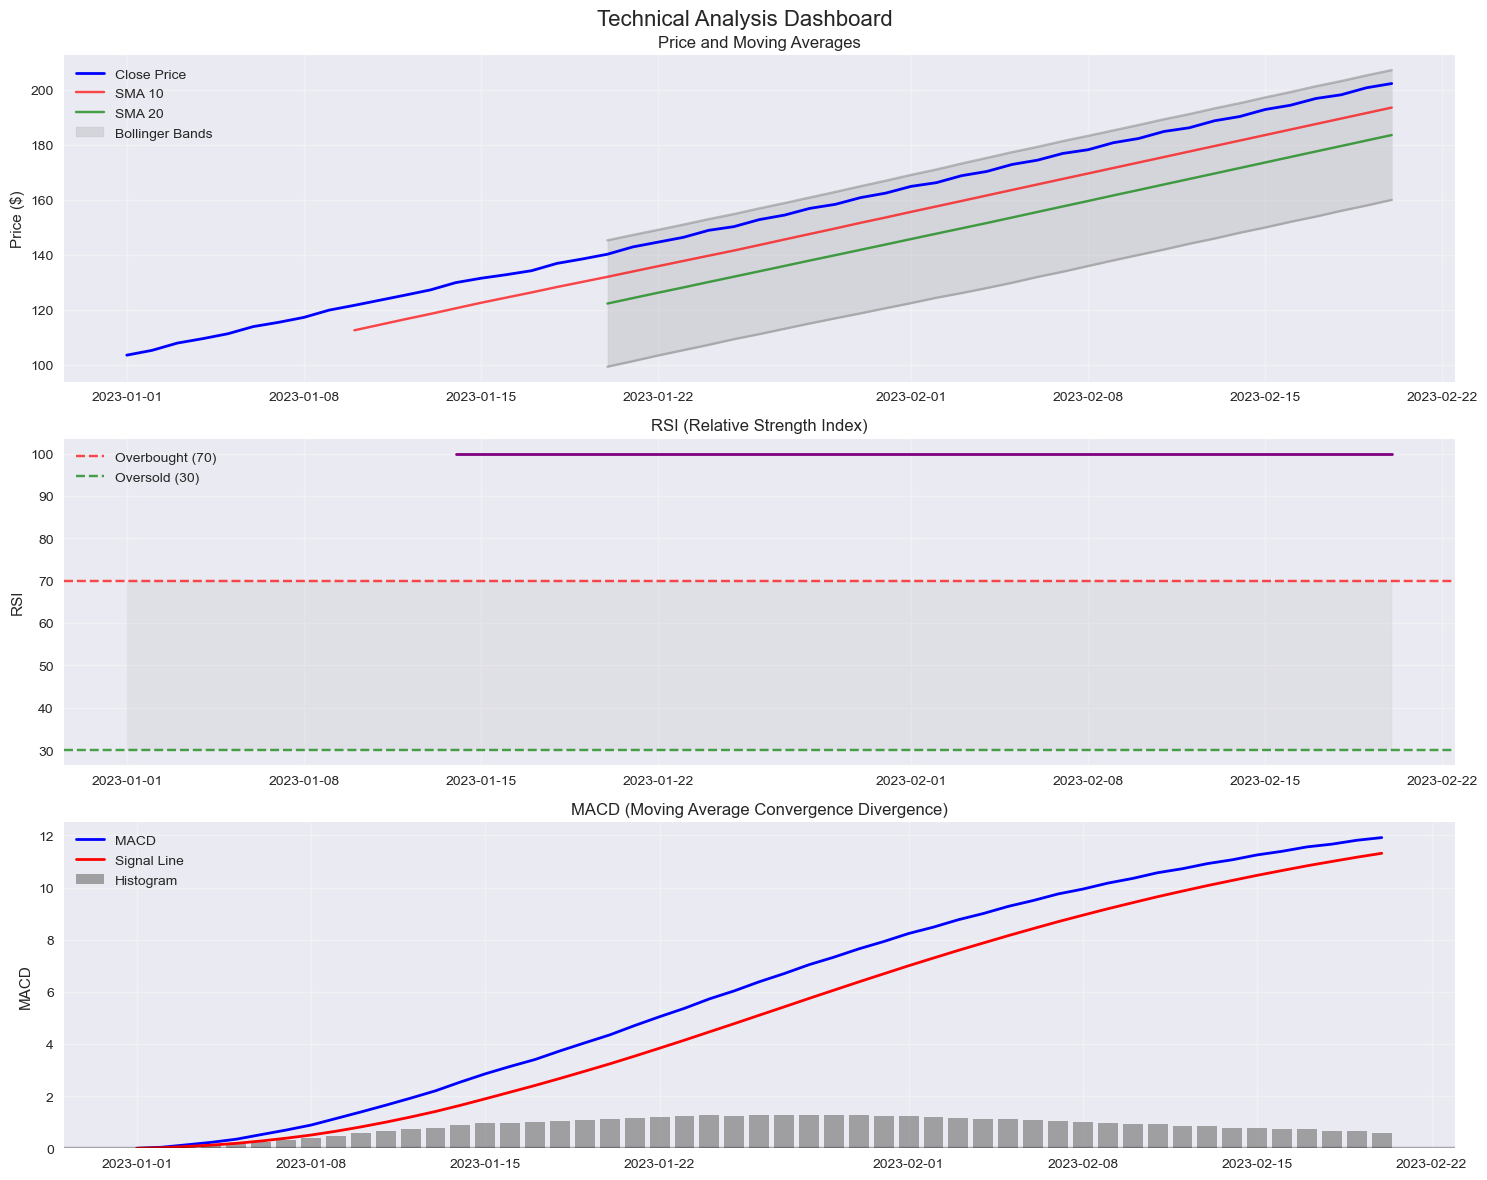

Technical Indicators Summary:
Current RSI: 100.00
Current MACD: 11.9167
Price vs SMA 20: 10.22%


In [4]:
# Calculate technical indicators
def calculate_sma(prices, window):
    """Simple Moving Average"""
    return prices.rolling(window=window).mean()

def calculate_ema(prices, window):
    """Exponential Moving Average"""
    return prices.ewm(span=window).mean()

def calculate_rsi(prices, window=14):
    """Relative Strength Index"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(prices, window=20):
    """Bollinger Bands"""
    sma = calculate_sma(prices, window)
    std = prices.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return upper_band, sma, lower_band

# Calculate indicators
df['SMA_10'] = calculate_sma(df['close'], 10)
df['SMA_20'] = calculate_sma(df['close'], 20)
df['EMA_12'] = calculate_ema(df['close'], 12)
df['EMA_26'] = calculate_ema(df['close'], 26)
df['RSI'] = calculate_rsi(df['close'])
df['BB_upper'], df['BB_middle'], df['BB_lower'] = calculate_bollinger_bands(df['close'])

# MACD calculation
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['MACD_signal'] = calculate_ema(df['MACD'], 9)
df['MACD_histogram'] = df['MACD'] - df['MACD_signal']

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('Technical Analysis Dashboard', fontsize=16)

# Price and Moving Averages
ax1 = axes[0]
ax1.plot(df.index, df['close'], label='Close Price', linewidth=2, color='blue')
ax1.plot(df.index, df['SMA_10'], label='SMA 10', alpha=0.7, color='red')
ax1.plot(df.index, df['SMA_20'], label='SMA 20', alpha=0.7, color='green')
ax1.fill_between(df.index, df['BB_upper'], df['BB_lower'], alpha=0.2, color='gray', label='Bollinger Bands')
ax1.plot(df.index, df['BB_upper'], alpha=0.5, color='gray')
ax1.plot(df.index, df['BB_lower'], alpha=0.5, color='gray')
ax1.set_title('Price and Moving Averages')
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# RSI
ax2 = axes[1]
ax2.plot(df.index, df['RSI'], color='purple', linewidth=2)
ax2.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
ax2.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
ax2.fill_between(df.index, 30, 70, alpha=0.1, color='gray')
ax2.set_title('RSI (Relative Strength Index)')
ax2.set_ylabel('RSI')
ax2.legend()
ax2.grid(True, alpha=0.3)

# MACD
ax3 = axes[2]
ax3.plot(df.index, df['MACD'], label='MACD', linewidth=2, color='blue')
ax3.plot(df.index, df['MACD_signal'], label='Signal Line', linewidth=2, color='red')
ax3.bar(df.index, df['MACD_histogram'], label='Histogram', alpha=0.7, color='gray')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.set_title('MACD (Moving Average Convergence Divergence)')
ax3.set_ylabel('MACD')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("002.png")
plt.show()

print("Technical Indicators Summary:")
print(f"Current RSI: {df['RSI'].iloc[-1]:.2f}")
print(f"Current MACD: {df['MACD'].iloc[-1]:.4f}")
print(f"Price vs SMA 20: {((df['close'].iloc[-1] / df['SMA_20'].iloc[-1]) - 1) * 100:.2f}%")


## 3. ARIMA Forecasting


Stationarity Test for Close Prices:
ADF Statistic: 0.9366154921720986
p-value: 0.9935500382119905
Critical Values:
	1%: -3.5778480370438146
	5%: -2.925338105429433
	10%: -2.6007735310095064
Series is not stationary

Stationarity Test for Returns:
ADF Statistic: -1.7838831797399006
p-value: 0.38849209279508706
Critical Values:
	1%: -3.5885733964124715
	5%: -2.929885661157025
	10%: -2.6031845661157025
Series is not stationary

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                   40
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -26.810
Date:                Wed, 16 Jul 2025   AIC                             59.620
Time:                        00:09:31   BIC                             64.453
Sample:                    01-01-2023   HQIC                            61.324
                         - 02-09-2023                                       

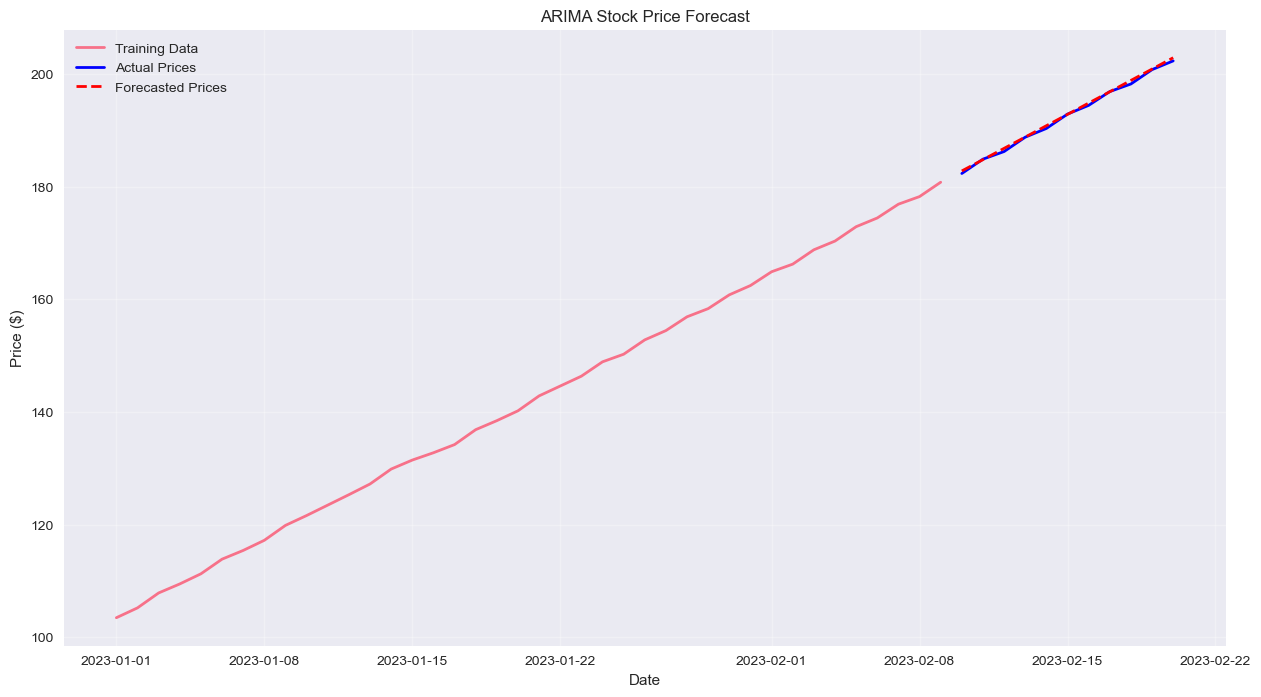


Next 5 Days Price Predictions:
2023-02-21: $182.80
2023-02-22: $184.81
2023-02-23: $186.82
2023-02-24: $188.83
2023-02-25: $190.84

Investment Recommendations:
Expected 5-day return: -5.69%
Recommendation: SELL - Downward trend expected


In [5]:
# ARIMA Forecasting
from statsmodels.tsa.arima.model import ARIMA

# Prepare data for ARIMA
df.index = pd.to_datetime(df.index)          # Ensure datetime index
df = df.asfreq('D')                          # Set frequency to daily
close_prices = df['close'].dropna()

# Check stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    
    if result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

print("Stationarity Test for Close Prices:")
check_stationarity(close_prices)

# Make series stationary if needed
returns = close_prices.pct_change().dropna()
print("\nStationarity Test for Returns:")
check_stationarity(returns)

# Split data for training and testing
train_size = int(len(close_prices) * 0.8)
train_data = close_prices[:train_size]
test_data = close_prices[train_size:]

# Fit ARIMA model
# model = ARIMA(train_data, order=(2, 1, 2))  # (p, d, q)
model = ARIMA(train_data, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)

fitted_model = model.fit()

print("\nARIMA Model Summary:")
print(fitted_model.summary())

# Make predictions
forecast_steps = len(test_data)
forecast = fitted_model.forecast(steps=forecast_steps)
forecast_index = test_data.index

# Calculate error metrics
mse = mean_squared_error(test_data, forecast)
mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mse)

print(f"\nForecast Performance:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Visualization
plt.figure(figsize=(15, 8))
plt.plot(train_data.index, train_data, label='Training Data', linewidth=2)
plt.plot(test_data.index, test_data, label='Actual Prices', linewidth=2, color='blue')
plt.plot(forecast_index, forecast, label='Forecasted Prices', linewidth=2, color='red', linestyle='--')
plt.title('ARIMA Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("003.png")
plt.show()

# Future predictions
future_forecast = fitted_model.forecast(steps=5)
future_dates = [df.index[-1] + timedelta(days=i+1) for i in range(5)]

print(f"\nNext 5 Days Price Predictions:")
for date, price in zip(future_dates, future_forecast):
    print(f"{date.strftime('%Y-%m-%d')}: ${price:.2f}")

print(f"\nInvestment Recommendations:")
current_price = close_prices.iloc[-1]
predicted_price = future_forecast[4]  # 5-day prediction
expected_return = ((predicted_price / current_price) - 1) * 100

if expected_return > 2:
    recommendation = "BUY - Strong upward trend expected"
elif expected_return > 0:
    recommendation = "HOLD - Modest gains expected"
elif expected_return > -2:
    recommendation = "HOLD - Minimal downside expected"
else:
    recommendation = "SELL - Downward trend expected"

print(f"Expected 5-day return: {expected_return:.2f}%")
print(f"Recommendation: {recommendation}")
